In [14]:
# 
# DATeS: Data Assimilation Testing Suite.
# Jupyter Tutorials.
#

# An example of a test driver:
# ==============================
# The driver file should be located in the root directory of DATeS.
# So; if it is not there, make a copy in the DATES_ROOT_PATH!
#
#     1- Create an object of the Lorenz96 model;
#     2- Create an of the DEnKF;
#     3- Run DEnKF using Lorenz96 over a defined observation, and assimilation timespan.
# 
#     To Run the driver:
#        On the linux terminal execute the following command:
#            $ python lorenze96_enkf_test_driver.py
#

In [15]:
import sys
import numpy as np
import os

In [16]:
# Define environment variables and update Python search path;
# this is a necessary call that must be inserted in the beginning of any driver.

import dates_setup
dates_setup.initialize_dates(random_seed=0)

import dates_utility as utility  # import DATeS utility module(s)

In [17]:
# Create a model object

from lorenz_models import Lorenz96  as Lorenz
model = Lorenz(model_configs={'create_background_errors_correlations':True})

In [18]:
# create observations' and assimilation checkpoints:

obs_checkpoints = np.arange(0, 5.001, 0.1)
da_checkpoints = obs_checkpoints

In [19]:
# Create DA pieces; this includes:
# ---------------------------------
#   i-   forecast trajectory/state
#   ii-  initial ensemble, 
#   iii- filter/smoother/hybrid object.

In [20]:
# create initial ensemble:

ensemble_size = 25
initial_ensemble = model.create_initial_ensemble(ensemble_size=ensemble_size)

In [21]:
# import, configure, and create filter object:

from EnKF import EnKF as StochasticEnKF
enkf_filter_configs = dict(model=model,
                           analysis_ensemble=initial_ensemble,
                           forecast_ensemble=None,
                           ensemble_size=ensemble_size,
                           inflation_factor=1.05,
                           obs_covariance_scaling_factor=1.0,
                           obs_adaptive_prescreening_factor=None,
                           localize_covariances=True,
                           localization_method='covariance_filtering',
                           localization_radius=4,
                           localization_function='gauss',
                           )

filter_obj = StochasticEnKF(filter_configs=enkf_filter_configs, 
                            output_configs=dict(file_output_moment_only=False)
                            )

In [22]:
# Create sequential DA process:
# -----------------------------

# + processing object; here this is a filtering_process object:

from filtering_process import FilteringProcess
experiment = FilteringProcess(assimilation_configs=dict(model=model,
                                                        filter=filter_obj,
                                                        obs_checkpoints=obs_checkpoints,
                                                        da_checkpoints=da_checkpoints,
                                                        forecast_first=True,
                                                        ref_initial_condition=model._reference_initial_condition.copy(),
                                                        ref_initial_time=0,
                                                        random_seed=0
                                                        ),
                              output_configs = dict(scr_output=True,
                                                    scr_output_iter=1,
                                                    file_output=True,
                                                    file_output_iter=1)
                              )


Caution: Unknown key detected: 'model'. Ignored and defaults are restored if necessary


In [23]:
# run the sequential filtering over the timespan created by da_checkpoints

experiment.recursive_assimilation_process()

Filtering:EnKF: FORECAST[time:1.000e-01 > RMSE:4.41799e-01]  :: ANALYSIS[time:1.000e-01 > RMSE:1.54857e-01]
Filtering:EnKF: FORECAST[time:2.000e-01 > RMSE:1.91746e-01]  :: ANALYSIS[time:2.000e-01 > RMSE:1.35688e-01]
Filtering:EnKF: FORECAST[time:3.000e-01 > RMSE:1.50330e-01]  :: ANALYSIS[time:3.000e-01 > RMSE:1.07414e-01]
Filtering:EnKF: FORECAST[time:4.000e-01 > RMSE:1.13204e-01]  :: ANALYSIS[time:4.000e-01 > RMSE:9.36892e-02]
Filtering:EnKF: FORECAST[time:5.000e-01 > RMSE:1.06511e-01]  :: ANALYSIS[time:5.000e-01 > RMSE:7.79400e-02]
Filtering:EnKF: FORECAST[time:6.000e-01 > RMSE:8.87518e-02]  :: ANALYSIS[time:6.000e-01 > RMSE:7.39435e-02]
Filtering:EnKF: FORECAST[time:7.000e-01 > RMSE:1.00197e-01]  :: ANALYSIS[time:7.000e-01 > RMSE:1.04900e-01]
Filtering:EnKF: FORECAST[time:8.000e-01 > RMSE:1.38874e-01]  :: ANALYSIS[time:8.000e-01 > RMSE:8.35335e-02]
Filtering:EnKF: FORECAST[time:9.000e-01 > RMSE:1.02409e-01]  :: ANALYSIS[time:9.000e-01 > RMSE:9.15324e-02]
Filtering:EnKF: FORECAST[tim

In [25]:
# retrieve/read  results:
out_dir_tree_structure_file = 'Results/Filtering_Results/output_dir_structure.txt'
filtering_results = read_filter_output(out_dir_tree_structure_file)

reference_states = filtering_results[2]
forecast_ensembles = filtering_results[3]
analysis_ensembles = filtering_results[5]
forecast_times = filtering_results[8]
analysis_times = filtering_results[9]
forecast_rmse = filtering_results[11]
analysis_rmse = filtering_results[12]
filter_configs = filtering_results[13]

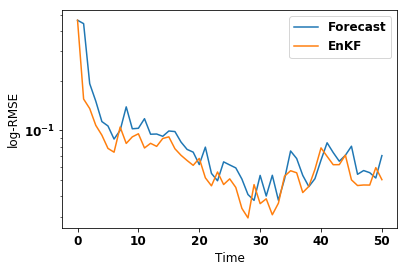

In [26]:
# 1- plot RMSE:

import matplotlib.pyplot as plt

fig_rmse = plt.figure(facecolor='white')
plt.semilogy(forecast_times, forecast_rmse, label='Forecast')
plt.semilogy(analysis_times, analysis_rmse, label=filter_configs['filter_name'])

plt.xlabel('Time')
plt.ylabel('log-RMSE')
xlables = [forecast_times[i] for i in xrange(0, len(forecast_times), 10)]
plt.xticks(xlables, 10*np.arange(len(xlables)))

plt.legend(loc='upper right')
plt.show()

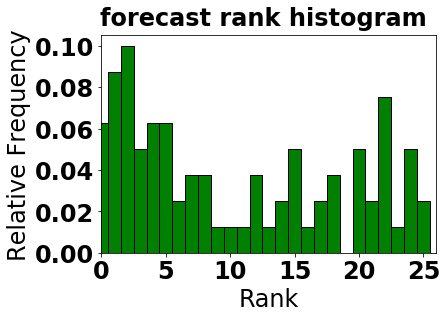

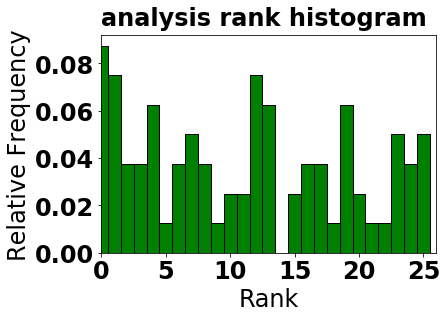

In [29]:
# 2- plot rank histogrmas:

_ = utility.rank_hist(forecast_ensembles, 
                      reference_states,
                      draw_hist=True, 
                      hist_type='relfreq',
                      hist_title='forecast rank histogram'
                     )
_ = utility.rank_hist(analysis_ensembles,
                      reference_states,
                      draw_hist=True,  
                      hist_type='relfreq', 
                      hist_title='analysis rank histogram'
                      )
plt.show()

In [30]:
# Clean executables and temporary modules:

utility.clean_executable_files()